In [5]:
# Import the yfinance. 
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np 
import plotly.express as px
import statsmodels.api as sm
from IPython.display import IFrame

In [23]:
start_date='2013-01-02'
end_date='2023-01-31'
#stock_ticker=['META', 'MSFT']
# Get the data for the stock META
meta_df = yf.download("META",start_date,end_date)
meta_df=meta_df.reset_index()
print("head:\n",meta_df.head())

# Get the data for the stock MSFT
msft_df = yf.download("MSFT",start_date,end_date)
msft_df=msft_df.reset_index()
print("head:\n",msft_df.head())

[*********************100%***********************]  1 of 1 completed
head:
         Date       Open       High        Low      Close  Adj Close    Volume
0 2013-01-02  27.440001  28.180000  27.420000  28.000000  28.000000  69846400
1 2013-01-03  27.879999  28.469999  27.590000  27.770000  27.770000  63140600
2 2013-01-04  28.010000  28.930000  27.830000  28.760000  28.760000  72715400
3 2013-01-07  28.690001  29.790001  28.650000  29.420000  29.420000  83781800
4 2013-01-08  29.510000  29.600000  28.860001  29.059999  29.059999  45871300
[*********************100%***********************]  1 of 1 completed
head:
         Date       Open       High        Low      Close  Adj Close    Volume
0 2013-01-02  27.250000  27.730000  27.150000  27.620001  22.717785  52899300
1 2013-01-03  27.629999  27.650000  27.160000  27.250000  22.413452  48294400
2 2013-01-04  27.270000  27.340000  26.730000  26.740000  21.993971  52521100
3 2013-01-07  26.770000  26.879999  26.639999  26.690001  21.952847 

In [53]:
meta = np.array(meta_df["Adj Close"].values.astype('float32')).reshape(meta_df.shape[0],1)
msft = np.array(msft_df["Adj Close"].values.astype('float32')).reshape(msft_df.shape[0],1)


In [110]:
t = np.array(meta_df["Date"].values.astype('float32')).reshape(meta_df.shape[0],1)

Plotting the stock adjusted close price timeseries

[*********************100%***********************]  2 of 2 completed


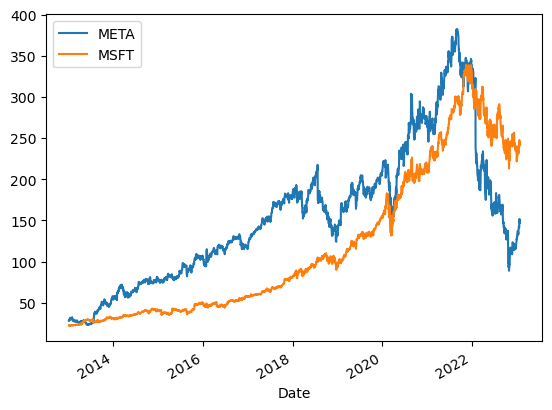

In [18]:
from matplotlib import pyplot as plt
# Plot the adjusted close prices
df1 = yf.download(['META', 'MSFT'],start_date,end_date)
# Plot the adjusted close prices
df1["Adj Close"].plot()
plt.show()

In [62]:
#-----------------------------------
#USER PARAM
#-----------------------------------

function        = 2      #1,2 (differnt funtion choices)
N               = len(meta)    #NUMBER OF DATA POINTS
fmin            = 1      #MIN FREQUENCY
EPOCHS          = 20

#GENERATOR FUNCTION PARAM
lookback            = 20         #number of timestep backwards to use
step                = 1          #use every data point 
delay               = 10          #number of timesteps in future
f_batch             = 0.01
lr                  = 0.001

In [51]:

#-----------------------------------
#PARTITION DATASET
#-----------------------------------

#TRAIN/VALIDATE SPLIT
B1=0;              B2=int(0.5*N);   
B3=B2;             B4=int(1.0*N)
batch_size         = max(1,int(f_batch*B2))   
batch_size_v       = max(1,int(f_batch*(B4-B3)))  

steps_per_epoch  = np.ceil(B2/batch_size)

print("BOUNDS",B1,B2,B3,B4)

BOUNDS 0 1268 1268 2537


Normalizing the data

META

In [54]:
#NORMALIZE USING TRAINING DATA MEAN/STD (B1 to B2)
meta_mean = meta[B1:B2].mean(axis=0)
meta -= meta_mean
meta_std = meta[B1:B2].std(axis=0)
meta /= meta_std

MSFT

In [55]:
#NORMALIZE USING TRAINING DATA MEAN/STD (B1 to B2)
msft_mean = msft[B1:B2].mean(axis=0)
msft -= msft_mean
msft_std = msft[B1:B2].std(axis=0)
msft /= msft_std

In [56]:
#-----------------------------------
#GENERATOR FUNCTION
#-----------------------------------

# data—The original array of floating-point data (normalized)
# lookback—How many timesteps back the input data should go.
# delay—How many timesteps in the future the target should be.
# min_index and max_index—Indices in the data array that delimit which time-
#      steps to draw from. This is useful for keeping a segment of the data for valida-
#      tion and another for testing.
# shuffle—Whether to shuffle the samples or draw them in chronological order.
# batch_size—The number of samples per batch.
# step—The period, in timesteps, at which you sample data. You’ll set it to 6 in
#       order to draw one data point every hour.
#NOTE: lookback/step must be an integer


def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):

    global indices_global

    #BEFORE WHILE IS ONLY EVALUATED ON FIRST PASS
    #FUTURE CALLS JUST ITERATE THE WHILE LOOP
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback; print(min_index,i)
    if(lookback % step !=0): print("ERROR: lookback not divisble by step !=0"); exit()
    # print("B",i,min_index,max_index,lookback,delay,step,batch_size); #exit()
    while 1: #INFINITE LOOP

        #GENERATE "batch_size" STARTING POINTS (ONE FOR EACH BATCH)

        #RANDOM STARTING POINTS
        if shuffle:
            rows = np.random.randint(
                min_index + lookback,
                max_index -  delay, size=batch_size)
         #CHRONOLOGICAL
        else: 
            #RESET AT END 
            if i + delay >= max_index:
                i = min_index + lookback #loop back to beginiing 

            #batch_size=3 i=73 --> rows=[73 74 75]    
            rows = np.arange(i-1, min(i + batch_size-1, max_index-delay))
            #INCREMENT FIRST STARTING POINT
            i += len(rows)
        #print("A",i,rows);# exit()

        #INIITIALIZE ARRAY TO STORE SAMPLES AND TARGETS
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))

        #FILL ARRAYS
        indices_global=[]; 
        #print("batch=",rows); print("(batchsize,lookback,step,delay)=",batch_size,lookback,step,delay)
        for j, row in enumerate(rows):
            # print(j,row)
            indices = [*range(rows[j] - lookback+1, rows[j]+1)]#, step)
            indices.reverse(); indices = indices[::step]; indices.reverse()
            indices_global.append(indices)
            #print("sample:",rows[j],indices,rows[j] + delay); #exit()
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][data.shape[-1]-1]
        #exit()

        yield samples, targets


Split the train/validation data-sets

META

In [57]:
#-----------------------------------
# INSTANTIATE GENERATORS
#-----------------------------------
meta_train_gen = generator(meta,
                      lookback=lookback,
                      delay=delay,
                      min_index=B1,
                      max_index=B2,
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)


meta_val_gen = generator(meta,
                      lookback=lookback,
                      delay=delay,
                      min_index=B3,
                      max_index=B4,
                      shuffle=False,
                      step=step,
                      batch_size=batch_size_v)
meta_val_steps = (B4 - B3 - lookback)



MSFT

In [58]:
#-----------------------------------
# INSTANTIATE GENERATORS
#-----------------------------------
msft_train_gen = generator(msft,
                      lookback=lookback,
                      delay=delay,
                      min_index=B1,
                      max_index=B2,
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)


msft_val_gen = generator(msft,
                      lookback=lookback,
                      delay=delay,
                      min_index=B3,
                      max_index=B4,
                      shuffle=False,
                      step=step,
                      batch_size=batch_size_v)
msft_val_steps = (B4 - B3 - lookback)

In [98]:
#-----------------------------------
#TRAINING 
#-----------------------------------

def plot1(history,title="ANN"):
    #PLOT HISTORY
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    #plt.savefig('HISTORY-'+title+'.png')   # save the figure to file
    plt.close()

def plot2(history,title="ANN"):
    #PLOT HISTORY
    rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    epochs = range(1, len(rmse) + 1)
    plt.figure()
    plt.plot(epochs, rmse, 'bo', label='Training rmse')
    plt.plot(epochs, val_rmse, 'b', label='Validation rmse')
    plt.title('Training and validation rmse')
    plt.legend()
    plt.show()
    #plt.savefig('HISTORY-'+title+'.png')   # save the figure to file
    plt.close()


#PLOT TEST DATA
def plot3(model,val_gen,data,title="ANN"):
    t1=[]; yv1=[]; yv2=[]

    for i1 in range(0,int((B4-B3)/batch_size_v)):
        samples, targets  = next(val_gen)
        #print(samples.shape,targets.shape,len(indices_global),model.predict(samples).shape)
        for i in range(0,len(indices_global)):
            yv2.append(model.predict(samples)[i,0])
            yv1.append(targets[i])
            t1.append(t[max(indices_global[i])+delay][0])
            #print(t1[i],yv1[i],yv2[i])

    plt.plot(t1, yv1, 'bo', label='test: exact')
    plt.plot(t1, yv2, 'ro', label='predicted')

    plt.plot(t[range(B3,B4)], data[B3:B4,-1],'r-', label='')
    plt.title('predictions')
    plt.legend()
    plt.show()


## RNN (w/ dropout)

META

In [106]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import keras
#-----------------------------------
#TRAINING
#-----------------------------------
### Simple RNN (w/ dropout) - include regularization (Dropout) 

input_shape=(lookback // step, meta.shape[-1])

print("---------------------------")
print("SimpleRNN")  
print("---------------------------")

model = Sequential() 
model.add(layers.SimpleRNN(32,activation='relu',input_shape=input_shape,recurrent_dropout=0.1)) 
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer=RMSprop(lr=lr), loss='mae', metrics=[keras.metrics.RootMeanSquaredError()]) 
model.summary()
history = model.fit_generator(meta_train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=meta_val_gen, validation_steps=meta_val_steps)


---------------------------
SimpleRNN
---------------------------
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/opt/anaconda3/envs/ANLY590/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/var/folders/yw/gg3f0s8n7pz9vc_vpk4_qj0h0000gn/T/ipykernel_49466/1527259570.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(meta_train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=meta_val_gen, validation_steps=meta_val_steps)


106/106 [==============================] - 5s 27ms/step - loss: 0.1854 - root_mean_squared_error: 0.2440 - val_loss: 0.3408 - val_root_mean_squared_error: 0.4357
Epoch 2/20
106/106 [==============================] - 3s 29ms/step - loss: 0.1196 - root_mean_squared_error: 0.1619 - val_loss: 0.2770 - val_root_mean_squared_error: 0.3859
Epoch 3/20
106/106 [==============================] - 3s 26ms/step - loss: 0.1077 - root_mean_squared_error: 0.1422 - val_loss: 0.2800 - val_root_mean_squared_error: 0.3934
Epoch 4/20
106/106 [==============================] - 3s 27ms/step - loss: 0.0991 - root_mean_squared_error: 0.1306 - val_loss: 0.2827 - val_root_mean_squared_error: 0.3987
Epoch 5/20
106/106 [==============================] - 3s 29ms/step - loss: 0.0940 - root_mean_squared_error: 0.1247 - val_loss: 0.2758 - val_root_mean_squared_error: 0.3815
Epoch 6/20
106/106 [==============================] - 3s 25ms/step - loss: 0.0940 - root_mean_squared_error: 0.1238 - val_loss: 0.3011 - val_root_

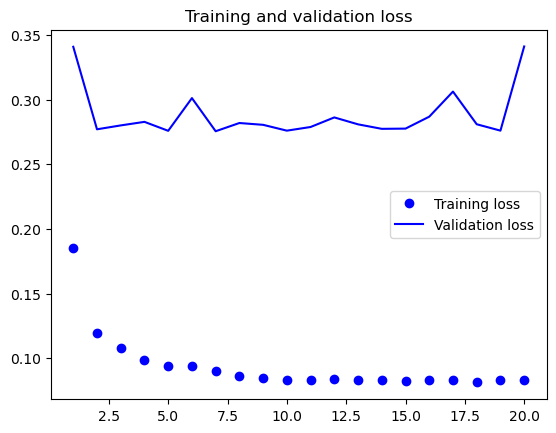

In [107]:
# MAE
plot1(history,"DFF")

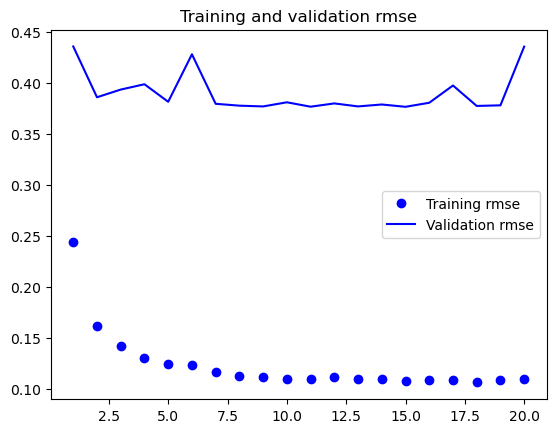

In [108]:
#RMSE
plot2(history,"DFF")

1/1 [==============================] - 0s 19ms/step


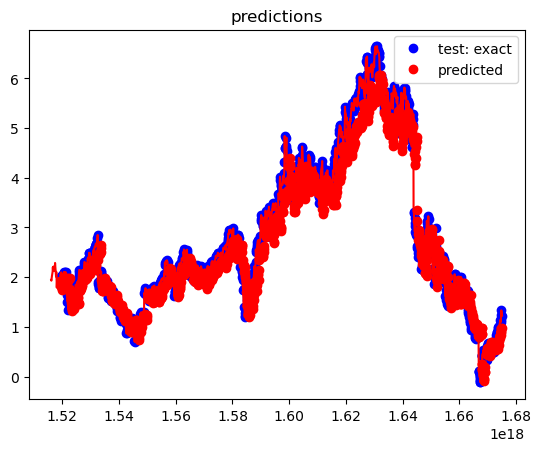

In [111]:
#prediction
plot3(model,meta_val_gen,meta,"DFF")

In [122]:
meta_val_gen = generator(meta,
                      lookback=lookback,
                      delay=delay,
                      min_index=B3,
                      max_index=B4,
                      shuffle=False,
                      step=step,
                      batch_size=batch_size_v)

<generator object generator at 0x7f8b36f9c270>

In [144]:
meta_samples, meta_targets  = next(meta_val_gen)

In [123]:
# evaluate the model
results=model.evaluate(meta_samples,meta_targets)
results

1/1 [==============================] - 0s 146ms/step - loss: 0.2203 - root_mean_squared_error: 0.2312


[0.22028882801532745, 0.23124609887599945]

MSFT

In [127]:
#-----------------------------------
#TRAINING
#-----------------------------------
### Simple RNN (w/ dropout) - include regularization (Dropout) 

input_shape=(lookback // step, msft.shape[-1])

print("---------------------------")
print("SimpleRNN")  
print("---------------------------")

model = Sequential() 
model.add(layers.SimpleRNN(32,activation='relu',input_shape=input_shape,recurrent_dropout=0.1)) 
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer=RMSprop(lr=lr), loss='mae', metrics=[keras.metrics.RootMeanSquaredError()]) 
model.summary()
history = model.fit_generator(msft_train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=msft_val_gen, validation_steps=msft_val_steps)


---------------------------
SimpleRNN
---------------------------
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 32)                1088      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


/opt/anaconda3/envs/ANLY590/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/var/folders/yw/gg3f0s8n7pz9vc_vpk4_qj0h0000gn/T/ipykernel_49466/1867879696.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(msft_train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=msft_val_gen, validation_steps=msft_val_steps)


0 20
Epoch 1/20
106/106 [==============================] - 8s 56ms/step - loss: 0.2985 - root_mean_squared_error: 0.4749 - val_loss: 1.0871 - val_root_mean_squared_error: 1.4575
Epoch 2/20
106/106 [==============================] - 3s 30ms/step - loss: 0.1571 - root_mean_squared_error: 0.2185 - val_loss: 0.5538 - val_root_mean_squared_error: 0.8092
Epoch 3/20
106/106 [==============================] - 3s 30ms/step - loss: 0.1301 - root_mean_squared_error: 0.1807 - val_loss: 0.5241 - val_root_mean_squared_error: 0.7501
Epoch 4/20
106/106 [==============================] - 3s 28ms/step - loss: 0.1178 - root_mean_squared_error: 0.1584 - val_loss: 0.8115 - val_root_mean_squared_error: 1.0226
Epoch 5/20
106/106 [==============================] - 4s 34ms/step - loss: 0.1174 - root_mean_squared_error: 0.1600 - val_loss: 0.6500 - val_root_mean_squared_error: 0.8388
Epoch 6/20
106/106 [==============================] - 3s 25ms/step - loss: 0.1129 - root_mean_squared_error: 0.1546 - val_loss: 0.

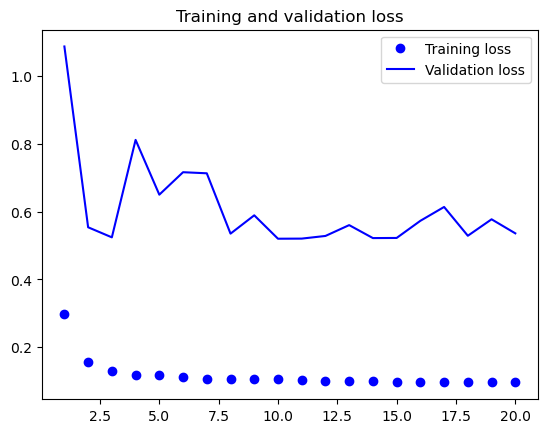

In [128]:
# MAE
plot1(history,"DFF")

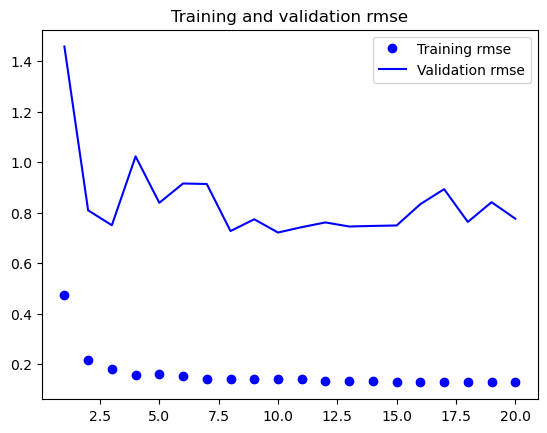

In [129]:
#RMSE
plot2(history,"DFF")

1/1 [==============================] - 0s 24ms/step


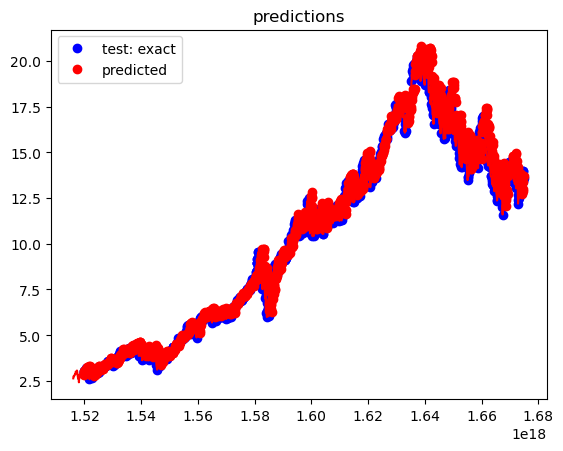

In [130]:
#prediction
plot3(model,msft_val_gen,msft,"DFF")

In [142]:
msft_samples, msft_targets  = next(msft_val_gen)

In [132]:
# evaluate the model
results=model.evaluate(samples,targets)
results

1/1 [==============================] - 0s 30ms/step - loss: 0.0570 - root_mean_squared_error: 0.0726


[0.05697997286915779, 0.07258956134319305]

## GRU (w/ dropout)

META

In [184]:
#-----------------------------------
#TRAINING
#-----------------------------------
### GRU (w/ dropout) - include regularization (Dropout) 

input_shape=(lookback // step, meta.shape[-1])

print("---------------------------")
print("GRU")  
print("---------------------------")

model = Sequential() 
model.add(layers.GRU(32,activation='relu',input_shape=input_shape,dropout=0.1,recurrent_dropout=0.5)) 
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer=RMSprop(lr=lr), loss='mae', metrics=[keras.metrics.RootMeanSquaredError()]) 
model.summary()
history = model.fit_generator(meta_train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=meta_val_gen, validation_steps=meta_val_steps)


---------------------------
GRU
---------------------------
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


/opt/anaconda3/envs/ANLY590/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/var/folders/yw/gg3f0s8n7pz9vc_vpk4_qj0h0000gn/T/ipykernel_49466/2935617460.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(meta_train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=meta_val_gen, validation_steps=meta_val_steps)


Epoch 1/20
106/106 [==============================] - 12s 63ms/step - loss: 0.4033 - root_mean_squared_error: 0.6236 - val_loss: 0.3618 - val_root_mean_squared_error: 0.4590
Epoch 2/20
106/106 [==============================] - 7s 64ms/step - loss: 0.1995 - root_mean_squared_error: 0.3120 - val_loss: 0.4806 - val_root_mean_squared_error: 0.6144
Epoch 3/20
106/106 [==============================] - 6s 53ms/step - loss: 0.1651 - root_mean_squared_error: 0.2443 - val_loss: 0.7117 - val_root_mean_squared_error: 0.9355
Epoch 4/20
106/106 [==============================] - 6s 54ms/step - loss: 0.1395 - root_mean_squared_error: 0.2008 - val_loss: 1.0393 - val_root_mean_squared_error: 1.3295
Epoch 5/20
106/106 [==============================] - 7s 62ms/step - loss: 0.1375 - root_mean_squared_error: 0.1896 - val_loss: 0.9535 - val_root_mean_squared_error: 1.2687
Epoch 6/20
106/106 [==============================] - 6s 61ms/step - loss: 0.1317 - root_mean_squared_error: 0.1822 - val_loss: 0.8744

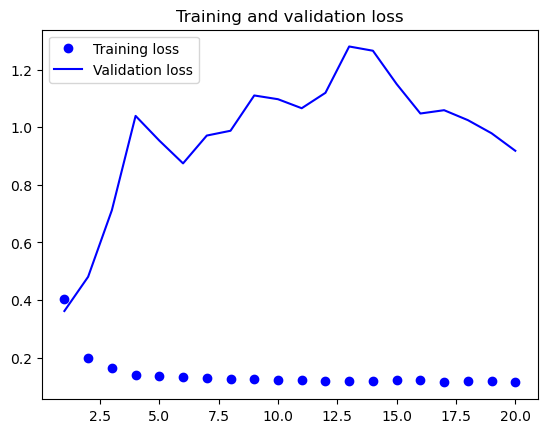

In [185]:
# MAE
plot1(history,"DFF")

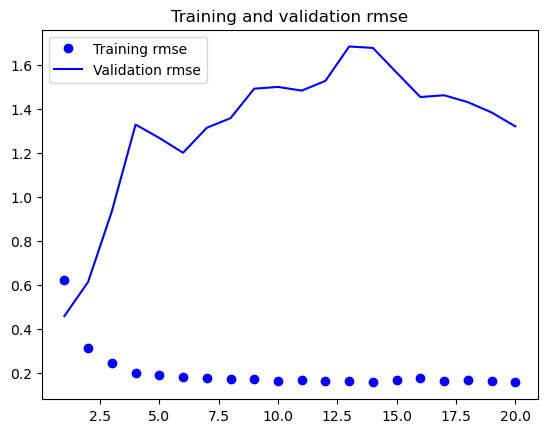

In [186]:
#RMSE
plot2(history,"DFF")

1/1 [==============================] - 0s 25ms/step


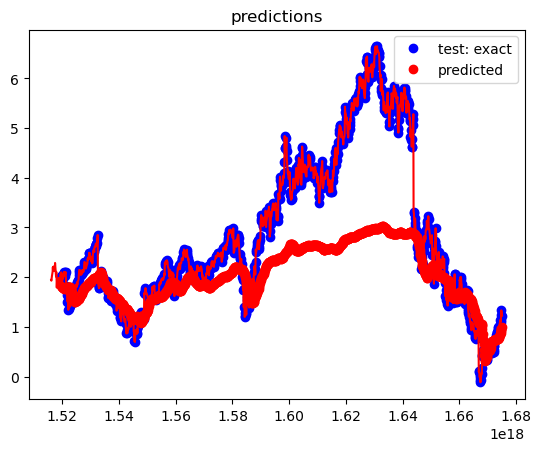

In [187]:
#prediction
plot3(model,meta_val_gen,meta,"DFF")

In [188]:
# evaluate the model
results=model.evaluate(meta_samples,meta_targets)
results

1/1 [==============================] - 0s 39ms/step - loss: 0.0977 - root_mean_squared_error: 0.1099


[0.09767091274261475, 0.10994305461645126]

MSFT

In [189]:
#-----------------------------------
#TRAINING
#-----------------------------------
### GRU (w/ dropout) - include regularization (Dropout) 

input_shape=(lookback // step, msft.shape[-1])

print("---------------------------")
print("GRU")  
print("---------------------------")

model = Sequential() 
model.add(layers.GRU(32,activation='relu',input_shape=input_shape,dropout=0.1,recurrent_dropout=0.5)) 
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer=RMSprop(lr=lr), loss='mae', metrics=[keras.metrics.RootMeanSquaredError()]) 
model.summary()
history = model.fit_generator(msft_train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=msft_val_gen, validation_steps=msft_val_steps)


---------------------------
GRU
---------------------------
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                3360      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/var/folders/yw/gg3f0s8n7pz9vc_vpk4_qj0h0000gn/T/ipykernel_49466/1622248034.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(msft_train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=msft_val_gen, validation_steps=msft_val_steps)


106/106 [==============================] - 12s 72ms/step - loss: 0.4407 - root_mean_squared_error: 0.5584 - val_loss: 3.8998 - val_root_mean_squared_error: 4.4163
Epoch 2/20
106/106 [==============================] - 12s 114ms/step - loss: 0.1640 - root_mean_squared_error: 0.2290 - val_loss: 0.8065 - val_root_mean_squared_error: 1.1800
Epoch 3/20
106/106 [==============================] - 7s 63ms/step - loss: 0.1530 - root_mean_squared_error: 0.2204 - val_loss: 1.7580 - val_root_mean_squared_error: 2.4766
Epoch 4/20
106/106 [==============================] - 6s 59ms/step - loss: 0.1426 - root_mean_squared_error: 0.2018 - val_loss: 3.2517 - val_root_mean_squared_error: 4.1862
Epoch 5/20
106/106 [==============================] - 6s 53ms/step - loss: 0.1425 - root_mean_squared_error: 0.1978 - val_loss: 3.7079 - val_root_mean_squared_error: 4.8460
Epoch 6/20
106/106 [==============================] - 5s 48ms/step - loss: 0.1340 - root_mean_squared_error: 0.1853 - val_loss: 4.5627 - val_ro

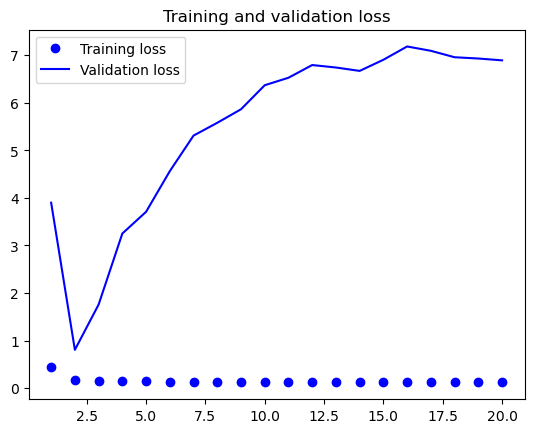

In [190]:
# MAE
plot1(history,"DFF")

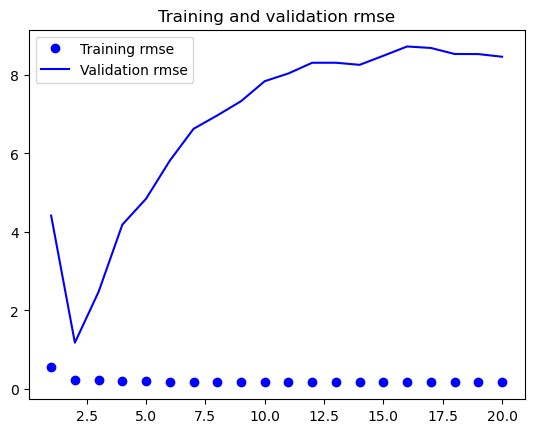

In [191]:
#RMSE
plot2(history,"DFF")

1/1 [==============================] - 0s 22ms/step


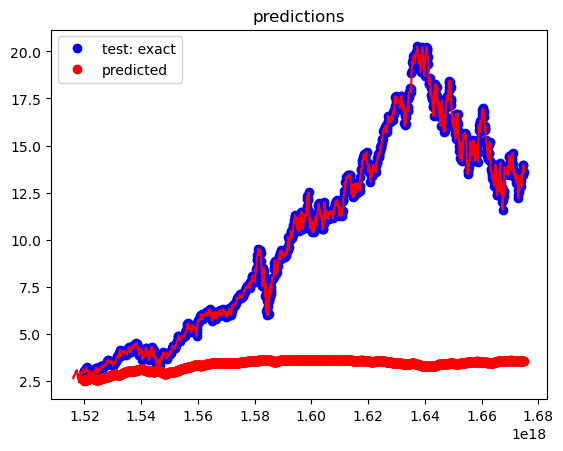

In [192]:
#prediction
plot3(model,msft_val_gen,msft,"DFF")

In [193]:
# evaluate the model
results=model.evaluate(msft_samples,msft_targets)
results

1/1 [==============================] - 0s 137ms/step - loss: 0.6055 - root_mean_squared_error: 0.6069


[0.605470597743988, 0.6068511605262756]

## LSTM (w/ dropout)

META

In [145]:
#-----------------------------------
#TRAINING
#-----------------------------------
print("---------------------------")
print("LSTM")  
print("---------------------------")

model = Sequential() 
model.add(layers.LSTM(32,activation='tanh',input_shape=input_shape,recurrent_dropout=0.1)) 
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer=RMSprop(), loss='mae', metrics=[keras.metrics.RootMeanSquaredError()]) 
model.summary()
history = model.fit_generator(meta_train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=meta_val_gen, validation_steps=meta_val_steps)


---------------------------
LSTM
---------------------------
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/var/folders/yw/gg3f0s8n7pz9vc_vpk4_qj0h0000gn/T/ipykernel_49466/3068314565.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(meta_train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=meta_val_gen, validation_steps=meta_val_steps)


106/106 [==============================] - 11s 64ms/step - loss: 0.1261 - root_mean_squared_error: 0.1973 - val_loss: 1.3847 - val_root_mean_squared_error: 2.0569
Epoch 2/20
106/106 [==============================] - 7s 66ms/step - loss: 0.1121 - root_mean_squared_error: 0.1553 - val_loss: 1.2717 - val_root_mean_squared_error: 1.8978
Epoch 3/20
106/106 [==============================] - 7s 63ms/step - loss: 0.1095 - root_mean_squared_error: 0.1519 - val_loss: 1.1826 - val_root_mean_squared_error: 1.8013
Epoch 4/20
106/106 [==============================] - 6s 57ms/step - loss: 0.1009 - root_mean_squared_error: 0.1378 - val_loss: 1.1190 - val_root_mean_squared_error: 1.7122
Epoch 5/20
106/106 [==============================] - 6s 58ms/step - loss: 0.0961 - root_mean_squared_error: 0.1310 - val_loss: 1.0659 - val_root_mean_squared_error: 1.6337
Epoch 6/20
106/106 [==============================] - 5s 45ms/step - loss: 0.0964 - root_mean_squared_error: 0.1309 - val_loss: 0.9893 - val_root

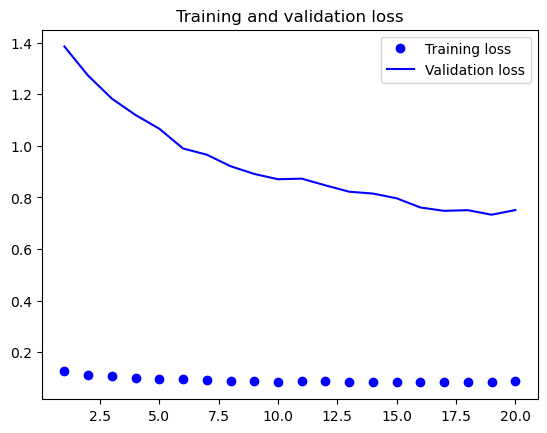

In [146]:
# MAE
plot1(history,"DFF")

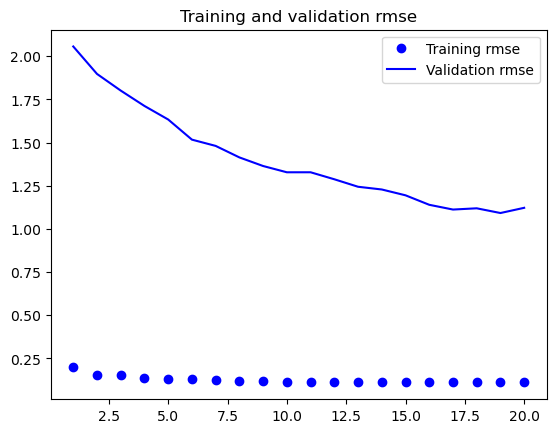

In [147]:
#RMSE
plot2(history,"DFF")

1/1 [==============================] - 0s 20ms/step


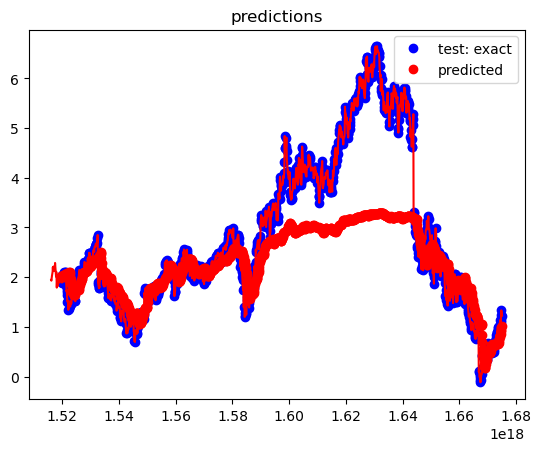

In [148]:
#prediction
plot3(model,meta_val_gen,meta,"DFF")

In [176]:
# evaluate the model
results=model.evaluate(meta_samples,meta_targets)
results

1/1 [==============================] - 0s 127ms/step - loss: 0.2685 - root_mean_squared_error: 0.3039


[0.26854947209358215, 0.3038758337497711]

MSFT

In [179]:
#-----------------------------------
#TRAINING
#-----------------------------------
print("---------------------------")
print("LSTM")  
print("---------------------------")

model = Sequential() 
model.add(layers.LSTM(32,activation='tanh',input_shape=input_shape,recurrent_dropout=0.1)) 
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer=RMSprop(), loss='mae', metrics=[keras.metrics.RootMeanSquaredError()]) 
model.summary()
history = model.fit_generator(msft_train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=msft_val_gen, validation_steps=msft_val_steps)


---------------------------
LSTM
---------------------------
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


/var/folders/yw/gg3f0s8n7pz9vc_vpk4_qj0h0000gn/T/ipykernel_49466/590405791.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(msft_train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=msft_val_gen, validation_steps=msft_val_steps)


Epoch 1/20
106/106 [==============================] - 14s 71ms/step - loss: 0.3014 - root_mean_squared_error: 0.4436 - val_loss: 9.3590 - val_root_mean_squared_error: 11.0032
Epoch 2/20
106/106 [==============================] - 7s 67ms/step - loss: 0.1436 - root_mean_squared_error: 0.2161 - val_loss: 8.9383 - val_root_mean_squared_error: 10.5936
Epoch 3/20
106/106 [==============================] - 5s 44ms/step - loss: 0.1289 - root_mean_squared_error: 0.1849 - val_loss: 8.5346 - val_root_mean_squared_error: 10.2939
Epoch 4/20
106/106 [==============================] - 4s 43ms/step - loss: 0.1245 - root_mean_squared_error: 0.1773 - val_loss: 8.2439 - val_root_mean_squared_error: 10.0291
Epoch 5/20
106/106 [==============================] - 6s 55ms/step - loss: 0.1158 - root_mean_squared_error: 0.1632 - val_loss: 8.0550 - val_root_mean_squared_error: 9.8013
Epoch 6/20
106/106 [==============================] - 5s 51ms/step - loss: 0.1134 - root_mean_squared_error: 0.1559 - val_loss: 7.

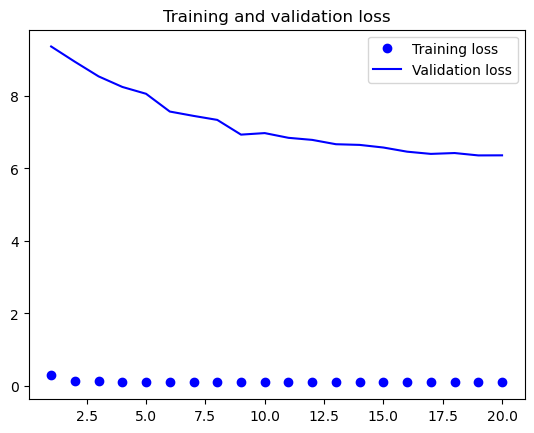

In [180]:
# MAE
plot1(history,"DFF")

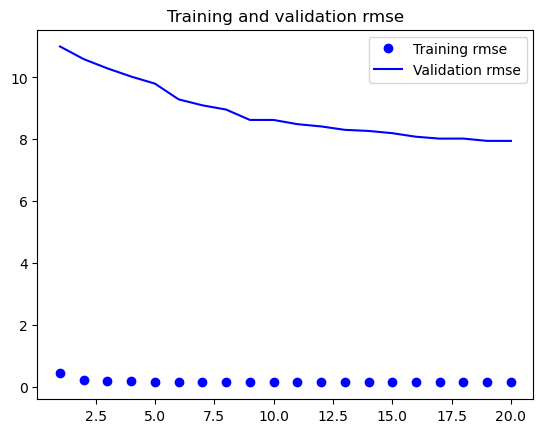

In [181]:
#RMSE
plot2(history,"DFF")

1/1 [==============================] - 0s 23ms/step


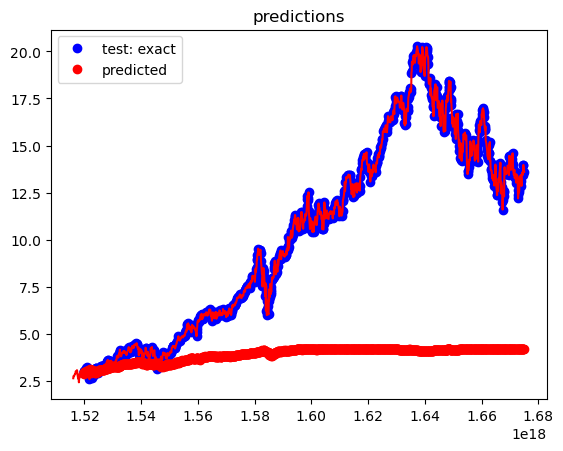

In [182]:
#prediction
plot3(model,msft_val_gen,msft,"DFF")

In [183]:
# evaluate the model
results=model.evaluate(msft_samples,msft_targets)
results

1/1 [==============================] - 0s 24ms/step - loss: 0.1656 - root_mean_squared_error: 0.1719


[0.165559783577919, 0.17191003262996674]